# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
ls

collectSubmission.sh*  knn.ipynb*             softmax.ipynb*
cs231n/                README.md*             start_ipython_osx.sh*
features.ipynb*        requirements.txt*      svm.ipynb*
frameworkpython*       setup_googlecloud.sh*  two_layer_net.ipynb*


## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


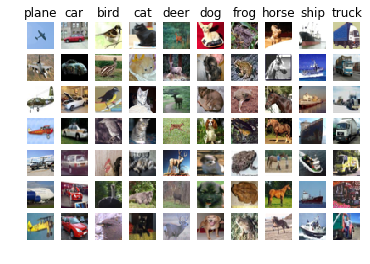

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


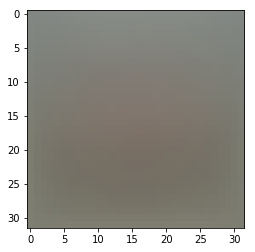

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.115267


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [12]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 5.180994 analytic: 5.180994, relative error: 8.088862e-11
numerical: -25.207654 analytic: -25.207654, relative error: 8.928204e-12
numerical: -12.212904 analytic: -12.212904, relative error: 1.950532e-11
numerical: -0.864576 analytic: -0.864576, relative error: 3.895325e-10
numerical: 25.128639 analytic: 25.128639, relative error: 1.995049e-11
numerical: 2.145466 analytic: 2.145466, relative error: 5.801794e-11
numerical: 1.827452 analytic: 1.827452, relative error: 3.725023e-11
numerical: 8.649517 analytic: 8.649517, relative error: 3.929562e-12
numerical: 7.950236 analytic: 7.950236, relative error: 1.884865e-11
numerical: 1.107980 analytic: 1.107980, relative error: 2.543041e-10
numerical: -0.410823 analytic: -0.410823, relative error: 1.162257e-09
numerical: -3.303738 analytic: -3.303738, relative error: 5.774391e-11
numerical: -14.728643 analytic: -14.728643, relative error: 9.899308e-12
numerical: -56.179155 analytic: -56.179155, relative error: 2.176181e-12
numerical:

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *loss function is not differentiable in 0, so gradient check at 0 will fail. Changing the margin in such a way that shifts the loss function from zero will decrease the frequency of this happening*

In [13]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.115267e+00 computed in 0.092157s
Vectorized loss: 9.115267e+00 computed in 0.004025s
difference: -0.000000


In [14]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.096428s
Vectorized loss and gradient: computed in 0.003467s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [49]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 415.014007
iteration 100 / 1500: loss 242.815333
iteration 200 / 1500: loss 149.645933
iteration 300 / 1500: loss 91.220392
iteration 400 / 1500: loss 57.577483
iteration 500 / 1500: loss 35.907535
iteration 600 / 1500: loss 23.690437
iteration 700 / 1500: loss 16.305474
iteration 800 / 1500: loss 11.568867
iteration 900 / 1500: loss 8.773124
iteration 1000 / 1500: loss 7.236029
iteration 1100 / 1500: loss 7.130536
iteration 1200 / 1500: loss 6.151476
iteration 1300 / 1500: loss 6.159848
iteration 1400 / 1500: loss 5.271106
That took 13.811723s


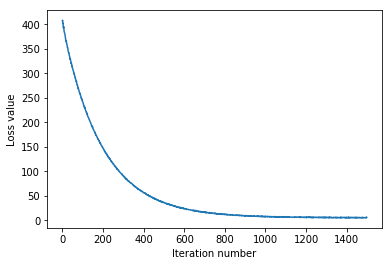

In [31]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [50]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.383184
validation accuracy: 0.388000


In [34]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
range_lern_rate = np.linspace(learning_rates[0],learning_rates[1],10)
range_reg = np.linspace(regularization_strengths[0],regularization_strengths[1],10)

for i in range_lern_rate:
    for j in range_reg:
        svm = LinearSVM()
        tic = time.time()
        loss_hist = svm.train(X_train, y_train, learning_rate=i, reg=j,num_iters=1500, verbose=True)
        toc = time.time()
        print('That took %fs' % (toc - tic))
        y_train_pred = svm.predict(X_train)
        train_accur = np.mean(y_train == y_train_pred)   
        y_val_pred = svm.predict(X_val)
        val_accur = np.mean(y_val == y_val_pred)
        results[(i, j)]=(train_accur, val_accur)
        
        if val_accur>best_val:
            best_val = val_accur
            best_svm = svm
            
           

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val) 

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 408.131822
iteration 100 / 1500: loss 243.536062
iteration 200 / 1500: loss 148.135369
iteration 300 / 1500: loss 90.347725
iteration 400 / 1500: loss 57.178788
iteration 500 / 1500: loss 36.266267
iteration 600 / 1500: loss 23.403200
iteration 700 / 1500: loss 16.253045
iteration 800 / 1500: loss 12.248625
iteration 900 / 1500: loss 9.752541
iteration 1000 / 1500: loss 7.639578
iteration 1100 / 1500: loss 6.157161
iteration 1200 / 1500: loss 5.641981
iteration 1300 / 1500: loss 5.648457
iteration 1400 / 1500: loss 5.992669
That took 13.700520s
iteration 0 / 1500: loss 445.965062
iteration 100 / 1500: loss 249.786977
iteration 200 / 1500: loss 144.849557
iteration 300 / 1500: loss 84.204399
iteration 400 / 1500: loss 50.124532
iteration 500 / 1500: loss 30.647958
iteration 600 / 1500: loss 20.111139
iteration 700 / 1500: loss 13.505534
iteration 800 / 1500: loss 9.791435
iteration 900 / 1500: loss 7.743270
iteration 1000 / 1500: loss 6.408414
iteration 1100 / 1

iteration 400 / 1500: loss 18.129590
iteration 500 / 1500: loss 16.378403
iteration 600 / 1500: loss 21.228781
iteration 700 / 1500: loss 28.470016
iteration 800 / 1500: loss 32.070238
iteration 900 / 1500: loss 15.203468
iteration 1000 / 1500: loss 26.305019
iteration 1100 / 1500: loss 25.431719
iteration 1200 / 1500: loss 25.740905
iteration 1300 / 1500: loss 27.523684
iteration 1400 / 1500: loss 23.747843
That took 13.589149s
iteration 0 / 1500: loss 625.266962
iteration 100 / 1500: loss 24.834282
iteration 200 / 1500: loss 28.741565
iteration 300 / 1500: loss 27.258496
iteration 400 / 1500: loss 18.073222
iteration 500 / 1500: loss 18.414656
iteration 600 / 1500: loss 21.364978
iteration 700 / 1500: loss 28.203236
iteration 800 / 1500: loss 22.104959
iteration 900 / 1500: loss 23.912110
iteration 1000 / 1500: loss 28.846897
iteration 1100 / 1500: loss 33.534143
iteration 1200 / 1500: loss 35.822429
iteration 1300 / 1500: loss 22.757336
iteration 1400 / 1500: loss 24.847229
That too

iteration 600 / 1500: loss 78.487726
iteration 700 / 1500: loss 65.280885
iteration 800 / 1500: loss 60.475350
iteration 900 / 1500: loss 85.218079
iteration 1000 / 1500: loss 57.580281
iteration 1100 / 1500: loss 68.268129
iteration 1200 / 1500: loss 72.957156
iteration 1300 / 1500: loss 53.163466
iteration 1400 / 1500: loss 76.880654
That took 13.611708s
iteration 0 / 1500: loss 783.539113
iteration 100 / 1500: loss 64.755702
iteration 200 / 1500: loss 84.576021
iteration 300 / 1500: loss 63.709358
iteration 400 / 1500: loss 75.978882
iteration 500 / 1500: loss 59.888391
iteration 600 / 1500: loss 100.589086
iteration 700 / 1500: loss 53.532098
iteration 800 / 1500: loss 64.145816
iteration 900 / 1500: loss 82.217738
iteration 1000 / 1500: loss 70.343716
iteration 1100 / 1500: loss 77.388139
iteration 1200 / 1500: loss 80.281488
iteration 1300 / 1500: loss 68.425575
iteration 1400 / 1500: loss 74.035548
That took 13.275575s
iteration 0 / 1500: loss 401.587205
iteration 100 / 1500: lo

iteration 500 / 1500: loss 184.241026
iteration 600 / 1500: loss 174.022269
iteration 700 / 1500: loss 207.757817
iteration 800 / 1500: loss 108.743162
iteration 900 / 1500: loss 118.129200
iteration 1000 / 1500: loss 138.201747
iteration 1100 / 1500: loss 179.051452
iteration 1200 / 1500: loss 192.034535
iteration 1300 / 1500: loss 140.604605
iteration 1400 / 1500: loss 184.825251
That took 14.350664s
iteration 0 / 1500: loss 531.479081
iteration 100 / 1500: loss 169.067910
iteration 200 / 1500: loss 184.871455
iteration 300 / 1500: loss 218.554381
iteration 400 / 1500: loss 180.060257
iteration 500 / 1500: loss 148.124011
iteration 600 / 1500: loss 158.979150
iteration 700 / 1500: loss 183.733610
iteration 800 / 1500: loss 168.312180
iteration 900 / 1500: loss 188.684705
iteration 1000 / 1500: loss 170.264035
iteration 1100 / 1500: loss 130.673953
iteration 1200 / 1500: loss 174.900094
iteration 1300 / 1500: loss 230.388944
iteration 1400 / 1500: loss 200.592299
That took 14.233248s


iteration 200 / 1500: loss 452.238762
iteration 300 / 1500: loss 452.351249
iteration 400 / 1500: loss 446.736121
iteration 500 / 1500: loss 467.143643
iteration 600 / 1500: loss 517.746173
iteration 700 / 1500: loss 437.947198
iteration 800 / 1500: loss 542.522195
iteration 900 / 1500: loss 406.246584
iteration 1000 / 1500: loss 406.640214
iteration 1100 / 1500: loss 483.908004
iteration 1200 / 1500: loss 466.886022
iteration 1300 / 1500: loss 515.243705
iteration 1400 / 1500: loss 499.227315
That took 13.427239s
iteration 0 / 1500: loss 708.145773
iteration 100 / 1500: loss 521.377939
iteration 200 / 1500: loss 498.660954
iteration 300 / 1500: loss 523.863007
iteration 400 / 1500: loss 549.498845
iteration 500 / 1500: loss 503.385998
iteration 600 / 1500: loss 579.467988
iteration 700 / 1500: loss 549.016669
iteration 800 / 1500: loss 530.719626
iteration 900 / 1500: loss 576.450676
iteration 1000 / 1500: loss 547.574587
iteration 1100 / 1500: loss 587.350209
iteration 1200 / 1500: l

iteration 1400 / 1500: loss 3007.196777
That took 13.731984s
iteration 0 / 1500: loss 402.567856
iteration 100 / 1500: loss 450.121110
iteration 200 / 1500: loss 661.488461
iteration 300 / 1500: loss 612.338540
iteration 400 / 1500: loss 515.507587
iteration 500 / 1500: loss 498.515606
iteration 600 / 1500: loss 474.661573
iteration 700 / 1500: loss 404.160561
iteration 800 / 1500: loss 472.813196
iteration 900 / 1500: loss 421.059048
iteration 1000 / 1500: loss 468.806929
iteration 1100 / 1500: loss 455.224084
iteration 1200 / 1500: loss 519.828835
iteration 1300 / 1500: loss 500.428534
iteration 1400 / 1500: loss 385.087503
That took 13.888922s
iteration 0 / 1500: loss 440.734907
iteration 100 / 1500: loss 449.092924
iteration 200 / 1500: loss 549.693164
iteration 300 / 1500: loss 601.493845
iteration 400 / 1500: loss 508.272735
iteration 500 / 1500: loss 537.672616
iteration 600 / 1500: loss 447.636801
iteration 700 / 1500: loss 487.961948
iteration 800 / 1500: loss 719.612337
itera

iteration 700 / 1500: loss 1811.577269
iteration 800 / 1500: loss 1691.973971
iteration 900 / 1500: loss 1745.347185
iteration 1000 / 1500: loss 1785.154184
iteration 1100 / 1500: loss 1703.090881
iteration 1200 / 1500: loss 1560.582566
iteration 1300 / 1500: loss 1780.924949
iteration 1400 / 1500: loss 2047.855663
That took 13.783670s
iteration 0 / 1500: loss 575.035111
iteration 100 / 1500: loss 2888.215266
iteration 200 / 1500: loss 2766.958313
iteration 300 / 1500: loss 3151.456897
iteration 400 / 1500: loss 3028.869363
iteration 500 / 1500: loss 3065.381862
iteration 600 / 1500: loss 3015.946277
iteration 700 / 1500: loss 3302.867742
iteration 800 / 1500: loss 2896.400062
iteration 900 / 1500: loss 2670.541571
iteration 1000 / 1500: loss 2974.471157
iteration 1100 / 1500: loss 3149.078751
iteration 1200 / 1500: loss 2773.910872
iteration 1300 / 1500: loss 2986.777599
iteration 1400 / 1500: loss 2869.109760
That took 13.841417s
iteration 0 / 1500: loss 611.743354
iteration 100 / 15

iteration 700 / 1500: loss 2582.623803
iteration 800 / 1500: loss 2421.918054
iteration 900 / 1500: loss 2320.624467
iteration 1000 / 1500: loss 2498.346948
iteration 1100 / 1500: loss 2399.879696
iteration 1200 / 1500: loss 2899.329817
iteration 1300 / 1500: loss 2612.187603
iteration 1400 / 1500: loss 2097.116011
That took 14.190611s
iteration 0 / 1500: loss 531.608702
iteration 100 / 1500: loss 4143.690551
iteration 200 / 1500: loss 4243.175278
iteration 300 / 1500: loss 4268.431765
iteration 400 / 1500: loss 3797.604851
iteration 500 / 1500: loss 4660.143678
iteration 600 / 1500: loss 4182.393184
iteration 700 / 1500: loss 4299.669668
iteration 800 / 1500: loss 4022.105336
iteration 900 / 1500: loss 4534.761454
iteration 1000 / 1500: loss 4030.276829
iteration 1100 / 1500: loss 4180.610585
iteration 1200 / 1500: loss 4984.537556
iteration 1300 / 1500: loss 4670.572301
iteration 1400 / 1500: loss 4856.863160
That took 13.772780s
iteration 0 / 1500: loss 580.753220
iteration 100 / 15

/home/ivan_radkevich_92/assignment1/cs231n/classifiers/linear_svm.py:90: RuntimeWarning: overflow encountered in double_scalars
  loss +=0.5* reg * np.sum(W * W)
/home/ivan_radkevich_92/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/ivan_radkevich_92/assignment1/cs231n/classifiers/linear_svm.py:90: RuntimeWarning: overflow encountered in multiply
  loss +=0.5* reg * np.sum(W * W)


iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
That took 13.597677s
iteration 0 / 1500: loss 788.580218
iteration 100 / 1500: loss 388579089000425894782026499779383525376.000000
iteration 200 / 1500: loss 64229011312475718923130526852877990470654037301916512668704699893797617664.000000
iteration 300 / 1500: loss 10616541164863388779090163776368712550611960855130940516353757661442993392043023292999599620178006985637101568.000000
iteration 400 / 1500: loss 1754829227510561393388678926867002399877326795203121727309975618607613152704062514399821525059615190449126095357517575863499386371056142850719744.000000
iteration 500 / 1500: loss 290059217018534319110348714605335051010767689005775016154101349677099323472471391215943298575533926464470056146700195612699137295681221764789144122735652457654466370410441558982656.000000
iteration 600 / 1500: loss 4794446551175809522289936771823248313975686650561641457136430547722526166858824039766125204021183

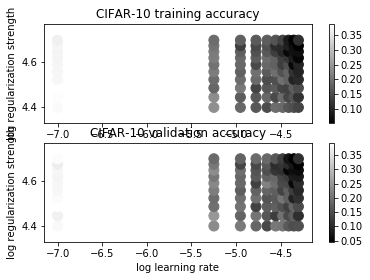

In [35]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [36]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.376000


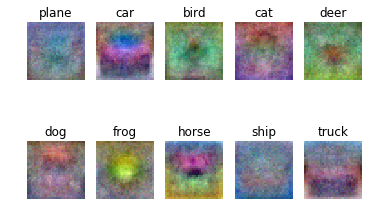

In [37]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *они выглядят как под кислотой. Они выглядят как размытые общие очертания рисунка,когда только проснёшься и открываешь глаза. Очертания неясные. Это связано с тем, что SVM проводит линии, разбивающие точки на классы, основываясь на сходстве пикселей, игнорируя края*